# 4.453x Creative Machine Learning for Design | Homework 1 💼
*Renaud Danhaive, Ous Abou Ras, Caitlin Mueller*
<br/><br/>
---

👋👋 Welcome to the first homework of 4.453x!! 😃🎈

In this assignment, you will train a model to recognize cats from dogs based on a limited dataset that we have pre-processed from the Kaggle Cats and Dogs dataset separately using Tensorflow's API (Tensorflow is another deep learning framework) which provides easy abstractions to download all kinds of datasets.

We worked through a very similar notebook in Lecture 1.  Like we saw in this first notebook on transfer learning with a tiny self-generated dataset, it's hard to make things work really well if your dataset is really too small. Here, we have a slightly more substantial dataset (still tiny in modern terms) that should help us achieve decent performance.

This notebook jumps ahead a bit in terms of machine learning concepts and implementation.  We will return to these concepts in a deeper, more systematic manner as we progress in the semester.  The purpose of this assignment and notebook is to help you build confidence programming in Colab notebook environments and get comfortable working with data and external libraries.

The code below provides a skeleton around the questions you are asked to complete. Questions and instructions are directly in the body of the notebook.

❗❗❗

The deliverable for this homework is a *viewable* link to your completed and runnable notebook that implements the requested code. For questions that require you to submit a textual or visual answer, please collect your results in a separate Google Docs file to be shared at the end of the notebook. For questions that request numerical results, you may simply print them with your code.

❗❗❗

Let's introduce some coding best practices. Why? Well, we need to read your code, but more importantly *you* may need to re-read your code at some point. Simple coding practices help you structure your mind and code faster.
We recommend the following practices:
- Explicit is better than implicit when naming objects. For example, a variable pointing to an array of dog images is better named as `dog_images_array` than as `d_array`.
- Don't repeat yourself (DRY). If you find yourself copy-pasting code, it's a good sign you should put that code in a function.
- Try to produce code that could almost be read as a sentence by somebody with some knowledge of what the code is trying to accomplish.
- More readable code is (almost always) better code.


## 0. Imports 📦

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import sklearn
from torch.utils.data import DataLoader

## 1. Download and inspect the dataset
We'll download the dataset to the local storage of this runtime. To do so easily, we'll use command line tool called `gdown` specifically designed to download files from Google Drive. In Colab, if you start a line of code with `!`, that line is run in the command line. This allows to install missing packages or download things easily from the web to the local storage. To install `gdown`, we just need to run `!pip install gdown`.

Note: you may have to run this cell twice to actually download the file to `dogs_cats.npz` as Colab sometimes returns a warning first.

In [2]:
!pip install gdown > /dev/null
!gdown https://drive.google.com/uc?id=102DjdS-5-0x4GQ12H49u0yFv31-4kc5O 

Downloading...
From: https://drive.google.com/uc?id=102DjdS-5-0x4GQ12H49u0yFv31-4kc5O
To: /content/processedDogCat.npz
100% 540M/540M [00:02<00:00, 219MB/s]


Ok, so we've got our dataset in the file `processedDogCat.npz`. `.npz` is a special format that can be read by `numpy`, so let's load the data contained in the file in a variable.

In [3]:
dataset = np.load("processedDogCat.npz", allow_pickle=True)

Let's inspect this dataset.

In [4]:
print(list(dataset.keys()))

['X', 'Y']


We see the dataset has two entries `X` (the input features or images) and `Y` the target classes.

In [5]:
X = dataset["X"]
Y = dataset["Y"]

### Question 1.1: Print the shapes of the X and Y arrays. How many samples are there in the dataset?  In other words, what are the dimensions of the X and Y arrays?  *Hint: the `np.shape` function may be useful here.*


In [6]:
print(X.shape, Y.shape)

# There are a 1000 samples in the dataset. 
# The X (input) key has 1000 images of size 150x150, each having a size 3 color 
# channel. The Y (label) key contains 1000 labels of size 1.

(1000, 150, 150, 3) (1000, 1)


### Question 1.2: Plot 5 random images from X (input)

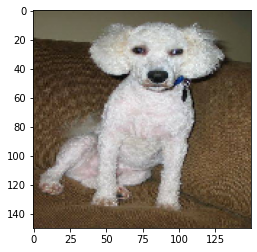

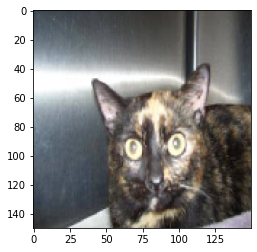

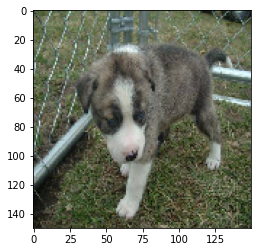

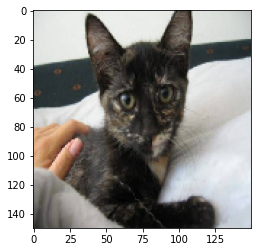

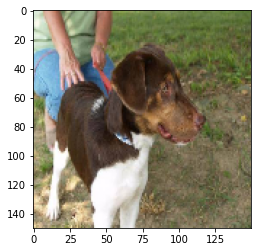

In [7]:
n_images = 5 # Number of images to plot
index = np.random.choice(X.shape[0], n_images)  # Randomly selecting 5 images

def plot_multiple_images(images, index):  # Function to stack and plot images
  for i in index:
    plt.figure()
    plt.imshow(images[i])
    plt.show()

  
plot_multiple_images(X, index) # Plotting

### Question 1.3: What are the target labels in Y and which one corresponds to the "Dog" category?

In [8]:
for i in index:  # Printing corresponding labels
  print(Y[i])

# The label that corresponds to dogs is : 0

[0.]
[1.]
[0.]
[1.]
[0.]




```
# This is formatted as code
```

Each datapoint in the dataset ia a 150-by-150 RGB image and its associated class. First, we'll shuffle the dataset because it is currently ordered by class (not something you usually want for training). Shuffling the dataset will also allow you to easily set aside a part of your dataset for validation/testing.

### Question 1.4: Shuffle the dataset using `sklearn.utils.shuffle`  Remember that we want to keep X and Y together so that the class labels stay with their associated images.

In [9]:
# Shuffling X and Y together
X,Y = sklearn.utils.shuffle(X,Y)

### Question 1.5: What is the range of the pixel values?

In [10]:
# Range is acquired by finding min and max of all pixel values
np.amin(X), np.amax(X)

(0.0, 1.0)

## 2. Processing the images into extracted features using VGG16
Take inspiration from the code in the [L01 notebook](https://colab.research.google.com/drive/1GTWORtS_bU__mH33_Mput_KYxYopqBuV?usp=sharing). Make sure to use the GPU!


You will need to resize the arrays/tensors from their current size (which is too small) to the minimum size accepted by VGG16 (224 by 224). To do so, we recommend you use `torchvision.transforms.Resize` (note this transformation can be applied on a batch of multiple images at once).

❗❗ Because we are handling many more images than we did in the lecture notebook, you may need to process them in batches (hint: you need to do it if you encounter a RAM or CUDA memory issue).

### Question 2.1: Convert the array X to a tensor

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Using GPU if available
cnn_model = torchvision.models.vgg16(pretrained=True).to(device) # importing model
cnn_model.eval() # setting to eval mode

X_tensor = torch.Tensor(X).permute(0,3,1,2).float().to(device) # Converting into a Tensor and permuting

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### Question 2.2: Resize the image tensors. Remember that we need to permute the array to format the tensors in the anticipated way.

In [12]:
img_transforms = [] # Creating a list of transforms
img_transforms.append(T.Resize(224)) # adding a resize for VGG16 minimum

### Question 2.3: Normalize the image tensors using the normalization constants expected by VGG16.

In [13]:
img_transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
                                  std=[0.229, 0.224, 0.225])) # normalization using imageNET values
img_processor = T.Compose(img_transforms) # Creating a composition of all transforms
X_processed = img_processor(X_tensor) # Processing the dataset of images

# test
X_processed.shape

torch.Size([1000, 3, 224, 224])

### Question 2.4: Project the image tensors to their bottleneck features

In [14]:
feature_extractor = cnn_model.features # Getting the feature extractor

batch_indices = np.arange(0,X_processed.shape[0], 50) # batching using a batch_size 50
batch_tensors = [X_processed[index:index + 50] for index in batch_indices] # batches

feature_tensors = [] 
with torch.no_grad():  # No gradients
  for i in batch_tensors:
    batch_features = feature_extractor(i) # getting feature tensors of each batch (~9 mins)
    feature_tensors.append(batch_features) # compiling feature tensors

X_features = torch.cat(feature_tensors, dim=0) # Catenating the list of feature tensor

# test
X_features.shape

torch.Size([1000, 512, 7, 7])

### Question 2.5: Flatten the resulting *feature maps* (not the batches!)

---



In [15]:
X_flat_features = X_features.reshape(X_features.shape[0],-1) # Flattening feature maps

# test
X_flat_features.shape

torch.Size([1000, 25088])

### Question 2.6: Convert the result back to numpy

In [16]:
X_numpy = X_flat_features.cpu().numpy() # Converting to numpy

# test
X_numpy.shape, type(X_numpy)

((1000, 25088), numpy.ndarray)

To be able to test how our model fares on unseen data, we need to set aside data that is not used during training. This data is our *validation* data and computing the accuracy of our model on this data gives us an idea of the *generalization error* of our model.

This is a really important process in ML, because in some sense predicting things perfectly on the training set does not matter (think of how stupidly replicating the data achieves perfect prediction). Generally, you would even want another test set, but we'll talk more about this in later weeks.

### Question 2.7: Separate the dataset in a training set (90% of the data) and a validation set (10% of the data)

In [17]:
from sklearn.model_selection import train_test_split # importing splitting library

val_percentage = 0.1 # percentage of dataset to be split for validation

X_train, X_validation, Y_train, Y_validation = train_test_split(X_numpy, Y, test_size=val_percentage, random_state=42, shuffle=False) # Splitting 90-10 with random state 42
# Since there is no stratify, they above code executes an ordered 900-100 split.

Y_train = Y_train.ravel() # Flattening Y_train
Y_validation = Y_validation.ravel() # Flattening Y_validation

# test
X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape

((900, 25088), (100, 25088), (900,), (100,))

## 3. Fit k-NN model
Like in the [L01 notebook](https://colab.research.google.com/drive/1GTWORtS_bU__mH33_Mput_KYxYopqBuV?usp=sharing), fit a k-nearest neighbors model with $k=10$ to your training set.

Remember, the task of the model is to try to predict whether a given image shows a dog or a cat. This is a VERY important model that could change the world as we know it. 🚨🚨🚨🚨

### Question 3.1: Fit a k-nearest neighbors model to your training set

In [18]:
import sklearn.neighbors  # importing KNN library

# Function for the entire knn workflow. returns predictions, training and validation accuracy,
# and indices of accurate and wrong predictions of the train/val dataset. It also
# returns "n_test_plots" random indices of accurate and wrong for plotting.

def knn_workflow(k, X_train, Y_train, X_validation, Y_validation, n_test_plots):
  knn = sklearn.neighbors.KNeighborsClassifier(k, weights="uniform") # initiating classifier
  knn.fit(X_train,Y_train)  # Fitting model
  
  # Computing accuracy for the validation set
  Y_predicted_val = knn.predict(X_validation) # Getting predictions
  results_val = np.where(Y_predicted_val == Y_validation, 1, 0) # Calculating accurate predictions
  accuracy_val = np.sum(results_val)/Y_predicted_val.shape[0] # Calculating accuracy

  # Computing accuracy for the training set
  Y_predicted_train = knn.predict(X_train) # Getting predictions
  results_train = np.where(Y_predicted_train == Y_train, 1, 0) # Calculating accurate predictions
  accuracy_train = np.sum(results_train)/Y_predicted_train.shape[0] # Calculating accuracy

  #Evaluating performance for Validation dataset
  accurate_val_idx = np.where(results_val==1)[0] # Finding indices of non-zero (accurate) predictions
  wrong_val_idx = np.where(results_val==0)[0] # Finding indices of zero (wrong) predictions

  # Selecting 5 random indices (adding 900 to account for the split from original data)
  plt_accurate_val = np.random.choice(accurate_val_idx, n_test_plots)
  plt_wrong_val = np.random.choice(wrong_val_idx, n_test_plots)

  # Evaluating performance for Training dataset
  accurate_train_idx = np.where(results_train==1)[0] # Finding indices of non-zero (accurate) predictions
  wrong_train_idx = np.where(results_train==0)[0] # Finding indices of zero (wrong) predictions

  # Selecting 5 random indices (adding 900 to account for the split from original data)
  plt_accurate_train = np.random.choice(accurate_train_idx, n_test_plots)
  plt_wrong_train = np.random.choice(wrong_train_idx, n_test_plots)

  # returns
  return (Y_predicted_train, Y_predicted_val, accuracy_train, accuracy_val, accurate_train_idx, 
          wrong_train_idx, accurate_val_idx, wrong_val_idx, plt_accurate_train, plt_wrong_train, 
          plt_accurate_val, plt_wrong_val)

In [19]:
(Y_predicted_train, Y_predicted_val, accuracy_train, accuracy_val, accurate_train_idx, 
 wrong_train_idx, accurate_val_idx, wrong_val_idx, plt_accurate_train, plt_wrong_train, 
 plt_accurate_val, plt_wrong_val) = knn_workflow(10, X_train, Y_train, X_validation, Y_validation, 5) # knn workflow for k=10 and no of plots = 5

### Question 3.2: Compute the accuracy of the model on the training and validation sets (separately). Is the model doing well? 
❗ Record the values found and your observations in the Google Doc you link at the end of the notebook.

Hint: we measure accuracy as `number_correct_predictions/total_number_predictions`. 

In [22]:
print("Model accuracy on the training set is : " + str(accuracy_train)) # Accuracy on training set
print("Model accuracy on the validation set is : " + str(accuracy_val)) # Accuracy on validation set

Model accuracy on the training set is : 0.8133333333333334
Model accuracy on the validation set is : 0.73


### Question 3.3: Plot images of 5 good predictions and 5 bad predictions. Can you observe patterns in the bad prediction?
❗ Record these images and your observations in the Google Doc you link at the end of the notebook.

Accurately predicted images



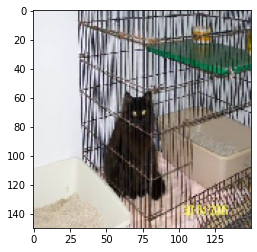

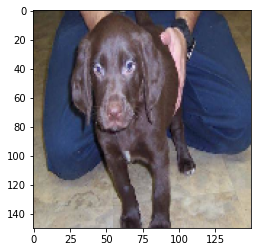

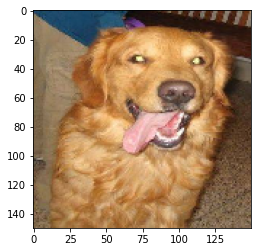

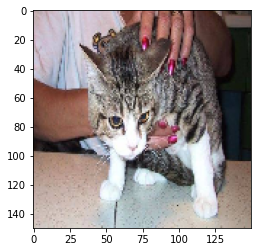

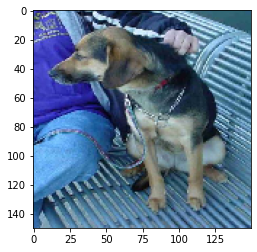

[1. 0. 0. 1. 0.]
Wrongly predicted images



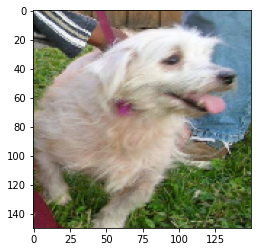

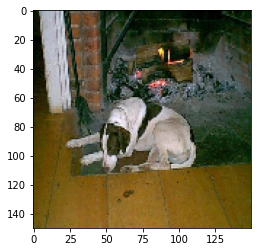

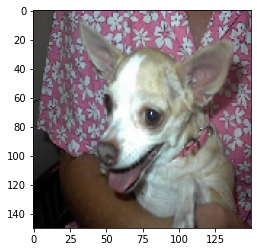

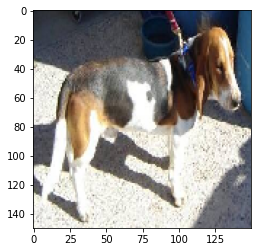

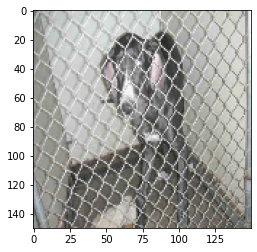

[1. 1. 1. 1. 1.]


In [24]:
# Plots of training set evaluation

print("Accurately predicted images\n")
plot_multiple_images(X,plt_accurate_train) # Plotting accurate predictions 
print(Y_predicted_train[plt_accurate_train]) # printing labels for evaluation

print("Wrongly predicted images\n")
plot_multiple_images(X,plt_wrong_train) # Plotting wrong prediction
print(Y_predicted_train[plt_wrong_train]) # printing labels for evaluation

Accurately predicted images



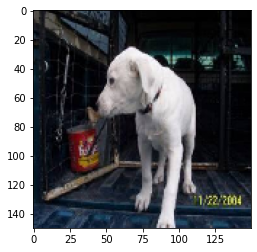

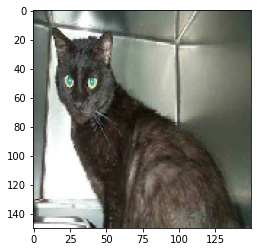

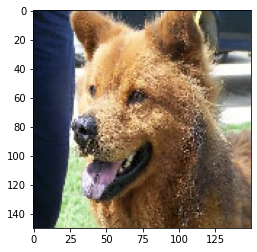

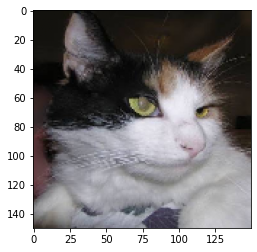

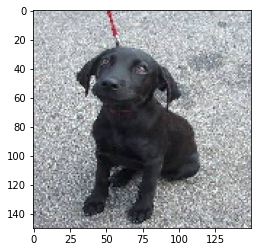

[0. 1. 0. 1. 0.]
Wrongly predicted images



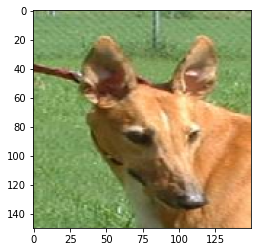

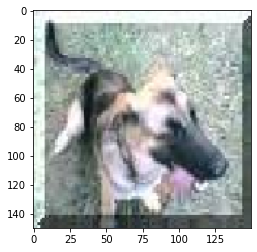

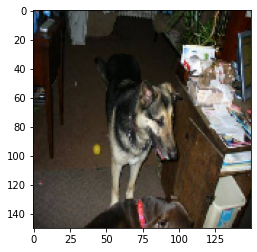

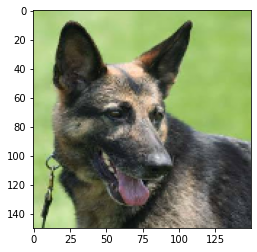

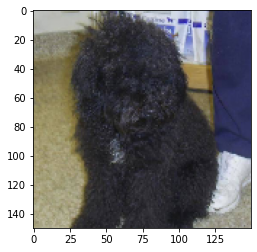

[1. 1. 1. 1. 1.]


In [23]:
# Plots of validation set evaluations

print("Accurately predicted images\n")
plot_multiple_images(X,plt_accurate_val + 900) # Plotting accurate predictions (adding 900 to account for index shift during split)
print(Y_predicted_val[plt_accurate_val]) # printing labels for evaluation

print("Wrongly predicted images\n")
plot_multiple_images(X,plt_wrong_val + 900) # Plotting wrong prediction (adding 900 to account for index shift during split)
print(Y_predicted_val[plt_wrong_val]) # printing labels for evaluation

### Question 3.4: Test 5 different values of $k$ and compute the validation accuracy of each resulting model. What is the best of value of $k$ that you found?
❗ Record your observations in the Google Doc you link at the end of the notebook.


In [30]:
# Checking accuracy values for k = 3,4,10,13,16,19

k_values = [2,3,4,10,13,16,19] # initiating values of k

# Evaluation loop for the different k values. (n_test_plots is 1 as we dont need it for now)

for i in k_values:
  (Y_predicted_train, Y_predicted_val, accuracy_train, accuracy_val, accurate_train_idx, 
   wrong_train_idx, accurate_val_idx, wrong_val_idx, plt_accurate_train, plt_wrong_train, 
   plt_accurate_val, plt_wrong_val) = knn_workflow(i, X_train, Y_train, X_validation, Y_validation, 1)

  print("For k = {}\nValidation Accuracy: {}\nTraining Accuracy: {}\n".format(i,accuracy_val,accuracy_train))

For k = 2
Validation Accuracy: 0.79
Training Accuracy: 0.9788888888888889

For k = 3
Validation Accuracy: 0.72
Training Accuracy: 0.8311111111111111

For k = 4
Validation Accuracy: 0.77
Training Accuracy: 0.9044444444444445

For k = 10
Validation Accuracy: 0.73
Training Accuracy: 0.8133333333333334

For k = 13
Validation Accuracy: 0.65
Training Accuracy: 0.7533333333333333

For k = 16
Validation Accuracy: 0.67
Training Accuracy: 0.7511111111111111

For k = 19
Validation Accuracy: 0.63
Training Accuracy: 0.7077777777777777



### Submit a link to the document where you recorded the requested observations below. Make sure it is viewable by the teaching staff. 

Your link 💻 > https://docs.google.com/document/d/1I-oS4AFkoGX4m6u3_KXTFfBg7RVsxOy7UcqrhPjHpW8/edit?usp=sharing

# Congratulations, you're done! 💪 There was a lot of brand new stuff here, you should be proud of yourself!! 👏⚡